[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Router

## 復習

私たちは、`messages` を状態として使用し、ツールを束ねたチャットモデルのグラフを作成しました。

このグラフは、以下の機能を持ちます

* ツール呼び出しを返す
* 自然言語による応答を返す

## 目標

これは、ユーザー入力に基づいて直接応答またはツール呼び出しをルーティングするチャットモデルのルーター(router)として考えることができます。

これは、LLMがツール呼び出しまたは直接応答によって制御フローを指示するエージェントの単純な例です。

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

グラフを拡張して、いずれかの出力で動作するようにしてみましょう! 

これには、次の2つのアイデアを使用できます。

(1) ツールを呼び出すノードを追加します。

(2) チャットモデルの出力を見て、ツール呼び出しノードにルーティングするか、ツール呼び出しが行われない場合は単に終了する条件付きエッジを追加します。



In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [1]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o-2024-08-06")
llm_with_tools = llm.bind_tools([multiply])

私たちは [組み込みの `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) を使用し、単に私たちのツールのリストを渡して初期化します。

条件付きエッジとして、[組み込みの `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) を使用します。


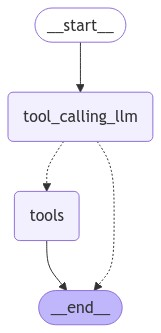

In [3]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.messages import BaseMessage

# Node
# def tool_calling_llm(state: MessagesState):
def tool_calling_llm(state: MessagesState) -> dict[str, list[BaseMessage]]:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello world.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

Hello! How can I assist you today?


In [6]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="What is 2 times 3?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_9BjqrSrHfgDzrA6blnDRcxwM)
 Call ID: call_9BjqrSrHfgDzrA6blnDRcxwM
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


さて、グラフがツールを実行していることがわかります!

`ToolMessage` で応答します。 

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Studio を実行するには現在 Mac が必要です。Mac を使用していない場合は、この手順をスキップしてください。*

--

`module-1/studio/router.py` を使用する `router` を Studio に読み込みます。これは `module-1/studio/langgraph.json` に設定されています。
